## Here we are creating a (.env) file to hide our API_KEY and API_ID

In [3]:
import pandas as pd
import requests
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import time


# Loading vairable from .env
load_dotenv()

#Getting them on this file

API_ID = os.getenv("ADZUNA_APP_ID")
API_KEY = os.getenv("ADZUNA_APP_KEY")

## Now we are calling the API key to extract data from the web database to our pandas dataframe(df)

In [ ]:
i = 1
url = f"https://api.adzuna.com/v1/api/jobs/gb/search/{i}?app_id={API_ID}&app_key={API_KEY}&results_per_page=20&what=javascript%20developer&content-type=application/json"
final_df = pd.DataFrame()

for i in range (1,300,1):
    response = requests.get(url)  # here the response variable is a object. Then in the next line we are converting response variable into json type.
    temp_data = response.json()['results']
    temp_df = pd.json_normalize(temp_data)
    final_df = pd.concat([final_df,temp_df],ignore_index=True)
    time.sleep(1)  # Here we are using this time method to create a small delay so we would hit the server API request limit.


    

In [ ]:
final_df['avg_salary'] = (final_df["salary_min"] + final_df["salary_max"]) / 2
final_df= final_df[['title','company.display_name','created','location.display_name','salary_max','salary_min','category.label','avg_salary']]
final_df.head()

# Now we are doing some EDA(Exploratory data analysis) to better understand the data we are working on

In [ ]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
print("Shape of dataset:", final_df.shape)
print("\nColumns:", final_df.columns.tolist())
print("\nMissing values:\n", final_df.isna().sum())

In [ ]:
# --- 2. Salary Preprocessing ---
avg_salary = (final_df["salary_min"] + final_df["salary_max"]) / 2



# --- 3. Top Job Titles ---
top_titles = final_df["title"].value_counts().head(10)
print("\nTop Job Titles:\n", top_titles)

plt.figure(figsize=(10,5))
sns.barplot(y=top_titles.index, x=top_titles.values)
plt.title("Top 10 Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Title")
plt.show()

In [ ]:
final_df.to_csv('dataset.csv')

In [5]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,title,company.display_name,created,location.display_name,salary_max,salary_min,category.label,avg_salary
0,0,JavaScript Developer - Hybrid (Manchester ),Circle Group,2025-08-20T13:27:38Z,"Manchester, Greater Manchester",40000.00,40000.00,IT Jobs,40000.00
1,1,Full-Stack Javascript Developer – Central Lond...,Nexus Jobs Limited,2025-08-13T14:20:32Z,"London, UK",44198.56,44198.56,IT Jobs,44198.56
2,2,Javascript Developer,Track24,2025-09-06T00:35:08Z,"Finsbury, Central London",60000.00,60000.00,IT Jobs,60000.00
3,3,Javascript Developer,Lloyds Bank,2025-08-31T17:44:01Z,UK,58410.00,47790.00,IT Jobs,53100.00
4,4,JavaScript Developer,Sellick Partnership,2025-09-04T14:19:06Z,"Newcastle Upon Tyne, Tyne & Wear",55000.00,48000.00,IT Jobs,51500.00


In [6]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv('dataset.csv', index_col=0)

# ========================================
# FEATURE ENGINEERING
# ========================================

print(" FEATURE ENGINEERING")
print("-" * 40)

# 1. Create target variable (average salary)
df['avg_salary'] = (df['salary_min'] + df['salary_max']) / 2
print(" Created 'avg_salary' - target variable for prediction")

# 2. Handle datetime and create days since posted (FIXED VERSION)
df['created'] = pd.to_datetime(df['created'])

# Fix timezone compatibility
if df['created'].dt.tz is not None:
    current_time = pd.Timestamp.now(tz=df['created'].dt.tz)
else:
    current_time = pd.Timestamp.now()

df['days_since_posted'] = (current_time - df['created']).dt.days
df['days_since_posted'] = df['days_since_posted'].clip(lower=0)  # Remove negative values
print(" Created 'days_since_posted' - job posting age in days")

# 3. Title-based features
df['title_length'] = df['title'].str.len()
print(" Created 'title_length' - length of job title")

# 4. Binary features from job titles (1 = True, 0 = False)
df['is_senior'] = df['title'].str.contains('Senior|Lead|Principal', case=False, na=False).astype(int)
df['is_fullstack'] = df['title'].str.contains('Fullstack|Full Stack|Full-Stack', case=False, na=False).astype(int)
df['is_frontend'] = df['title'].str.contains('Frontend|Front End|Front-End', case=False, na=False).astype(int)
df['is_backend'] = df['title'].str.contains('Backend|Back End|Back-End', case=False, na=False).astype(int)
df['is_react'] = df['title'].str.contains('React', case=False, na=False).astype(int)
df['is_node'] = df['title'].str.contains('Node|NodeJS|Node.js', case=False, na=False).astype(int)

print(" Created binary features from job titles:")
print(f"   - is_senior: {df['is_senior'].sum()} jobs")
print(f"   - is_fullstack: {df['is_fullstack'].sum()} jobs") 
print(f"   - is_frontend: {df['is_frontend'].sum()} jobs")
print(f"   - is_backend: {df['is_backend'].sum()} jobs")
print(f"   - is_react: {df['is_react'].sum()} jobs")
print(f"   - is_node: {df['is_node'].sum()} jobs")

# 5. Salary-based features
df['salary_range'] = df['salary_max'] - df['salary_min']
df['salary_category'] = pd.cut(df['avg_salary'], 
                              bins=[0, 30000, 50000, 70000, float('inf')], 
                              labels=['Entry', 'Mid', 'Senior', 'Lead'])
print(" Created salary features:")
print(f"   - salary_range: difference between min and max salary")
print(f"   - salary_category: Entry/Mid/Senior/Lead based on salary")

# 6. Location-based features
df['is_london'] = df['location.display_name'].str.contains('London', case=False, na=False).astype(int)
df['is_remote'] = df['location.display_name'].str.contains('Remote|Work from home', case=False, na=False).astype(int)
print(" Created location features:")
print(f"   - is_london: {df['is_london'].sum()} jobs in London")
print(f"   - is_remote: {df['is_remote'].sum()} remote jobs")

# 7. Company name length (proxy for company size/type)
df['company_name_length'] = df['company.display_name'].str.len()
print(" Created 'company_name_length' - proxy for company type")

# 8. Summary statistics
print(f"\n FEATURE ENGINEERING SUMMARY:")
print(f"   Original columns: {len(['title', 'company.display_name', 'created', 'location.display_name', 'salary_max', 'salary_min', 'category.label'])}")
print(f"   New features created: 12")
print(f"   Total columns now: {len(df.columns)}")

# 9. Display new features summary
new_features = ['avg_salary', 'days_since_posted', 'title_length', 'is_senior', 
               'is_fullstack', 'is_frontend', 'is_backend', 'is_react', 'is_node',
               'salary_range', 'salary_category', 'is_london', 'is_remote', 'company_name_length']

print(f"\n NEW FEATURES OVERVIEW:")
for feature in new_features:
    if feature in df.columns:
        if df[feature].dtype in ['int64', 'float64']:
            print(f"   {feature}: {df[feature].min()} to {df[feature].max()}")
        else:
            print(f"   {feature}: {df[feature].value_counts().to_dict()}")

# Save the enhanced dataset
df.to_csv('dataset_with_features.csv')
print(f"\n Enhanced dataset saved as 'dataset_with_features.csv'")
print(f" Ready for machine learning!")

 FEATURE ENGINEERING
----------------------------------------
 Created 'avg_salary' - target variable for prediction
 Created 'days_since_posted' - job posting age in days
 Created 'title_length' - length of job title
 Created binary features from job titles:
   - is_senior: 1794 jobs
   - is_fullstack: 2392 jobs
   - is_frontend: 299 jobs
   - is_backend: 0 jobs
   - is_react: 0 jobs
   - is_node: 299 jobs
 Created salary features:
   - salary_range: difference between min and max salary
   - salary_category: Entry/Mid/Senior/Lead based on salary
 Created location features:
   - is_london: 3289 jobs in London
   - is_remote: 0 remote jobs
 Created 'company_name_length' - proxy for company type

 FEATURE ENGINEERING SUMMARY:
   Original columns: 7
   New features created: 12
   Total columns now: 21

 NEW FEATURES OVERVIEW:
   avg_salary: 300.0 to 80000.0
   days_since_posted: 5 to 155
   title_length: 20 to 69
   is_senior: 0 to 1
   is_fullstack: 0 to 1
   is_frontend: 0 to 1
   is_b

# Preprocessing using Column Transformer

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# Load the enhanced dataset
df = pd.read_csv('dataset_with_features.csv', index_col=0)

print(" DATA PREPROCESSING WITH COLUMNTRANSFORMER")
print("=" * 50)
print(f"Dataset shape: {df.shape}")

# Define target variable
target = 'avg_salary'

# Define feature groups
categorical_features = [
    'location.display_name',
    'company.display_name', 
    'category.label',
    'salary_category'
]

numerical_features = [
    'title_length',
    'days_since_posted',
    'is_senior',
    'is_fullstack',
    'is_frontend',
    'is_backend',
    'is_react',
    'is_node',
    'salary_range',
    'is_london',
    'is_remote',
    'company_name_length'
]

all_features = categorical_features + numerical_features

print(f"\nFeatures to use:")
print(f"  Categorical: {len(categorical_features)} features")
print(f"  Numerical: {len(numerical_features)} features")
print(f"  Total: {len(all_features)} features")

# Prepare X and y
X = df[all_features].copy()
y = df[target].copy()

# Handle missing values
X = X.fillna('Unknown')

print(f"\nData prepared:")
print(f"  X shape: {X.shape}")
print(f"  y range: £{y.min():,.0f} to £{y.max():,.0f}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nData split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

print(f"\nColumnTransformer created with:")
print(f"  StandardScaler for numerical features")
print(f"  OneHotEncoder for categorical features")

# Fit and transform
print(f"\nApplying preprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"  Original features: {X_train.shape[1]}")
print(f"  Processed features: {X_train_processed.shape[1]}")

# Get feature names for reference
try:
    numerical_names = numerical_features
    categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_names + list(categorical_names)
    
    print(f"\nFeature transformation summary:")
    print(f"  Numerical features: {len(numerical_names)}")
    print(f"  Categorical features expanded to: {len(categorical_names)}")
    
except Exception as e:
    print(f"  Could not extract feature names: {e}")
    all_feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

# Save preprocessing artifacts
joblib.dump(preprocessor, 'preprocessor.pkl')
np.save('X_train_processed.npy', X_train_processed)
np.save('X_test_processed.npy', X_test_processed)  
np.save('y_train.npy', y_train.values)
np.save('y_test.npy', y_test.values)

# Save feature names
with open('feature_names.txt', 'w') as f:
    for name in all_feature_names:
        f.write(name + '\n')

print(f"\n PREPROCESSING COMPLETE!")
print(f"Files saved:")
print(f"  - preprocessor.pkl (ColumnTransformer)")
print(f"  - X_train_processed.npy ({X_train_processed.shape})")
print(f"  - X_test_processed.npy ({X_test_processed.shape})")
print(f"  - y_train.npy ({y_train.shape})")
print(f"  - y_test.npy ({y_test.shape})")
print(f"  - feature_names.txt ({len(all_feature_names)} features)")

print(f"\n Ready for model training!")

 DATA PREPROCESSING WITH COLUMNTRANSFORMER
Dataset shape: (5980, 21)

Features to use:
  Categorical: 4 features
  Numerical: 12 features
  Total: 16 features

Data prepared:
  X shape: (5980, 16)
  y range: £300 to £80,000

Data split:
  Training: 4784 samples
  Testing: 1196 samples

ColumnTransformer created with:
  StandardScaler for numerical features
  OneHotEncoder for categorical features

Applying preprocessing...
  Original features: 16
  Processed features: 42

Feature transformation summary:
  Numerical features: 12
  Categorical features expanded to: 30

 PREPROCESSING COMPLETE!
Files saved:
  - preprocessor.pkl (ColumnTransformer)
  - X_train_processed.npy ((4784, 42))
  - X_test_processed.npy ((1196, 42))
  - y_train.npy ((4784,))
  - y_test.npy ((1196,))
  - feature_names.txt (42 features)

 Ready for model training!


# Now Selecting adn training the best model

🤖 MACHINE LEARNING MODEL TRAINING
Data loaded:
  Training: 4784 samples, 42 features
  Testing: 1196 samples
  Salary range: £300 to £80,000

Training models...
  Training Linear Regression...
  Training Random Forest...
  Training Gradient Boosting...

📊 MODEL PERFORMANCE:
                         MAE       RMSE        R²  \
Linear Regression        0.0        0.0       1.0   
Random Forest            0.0        0.0       1.0   
Gradient Boosting  30.302136  33.918729  0.999997   

                                                         predictions  
Linear Regression  [40000.00000000004, 58267.19000000001, 48611.4...  
Random Forest      [40000.0, 58267.190000000104, 48611.4600000000...  
Gradient Boosting  [40035.74711880405, 58268.9280229647, 48587.03...  

🥇 BEST MODEL: Linear Regression
  R² Score: 1.000 (100.0% accuracy)
  Average Error: £0

📋 SAMPLE PREDICTIONS:
    Actual  Predicted    Error
------------------------------
£  40,000 £   40,000 £     0
£  58,267 £   58,267 £   

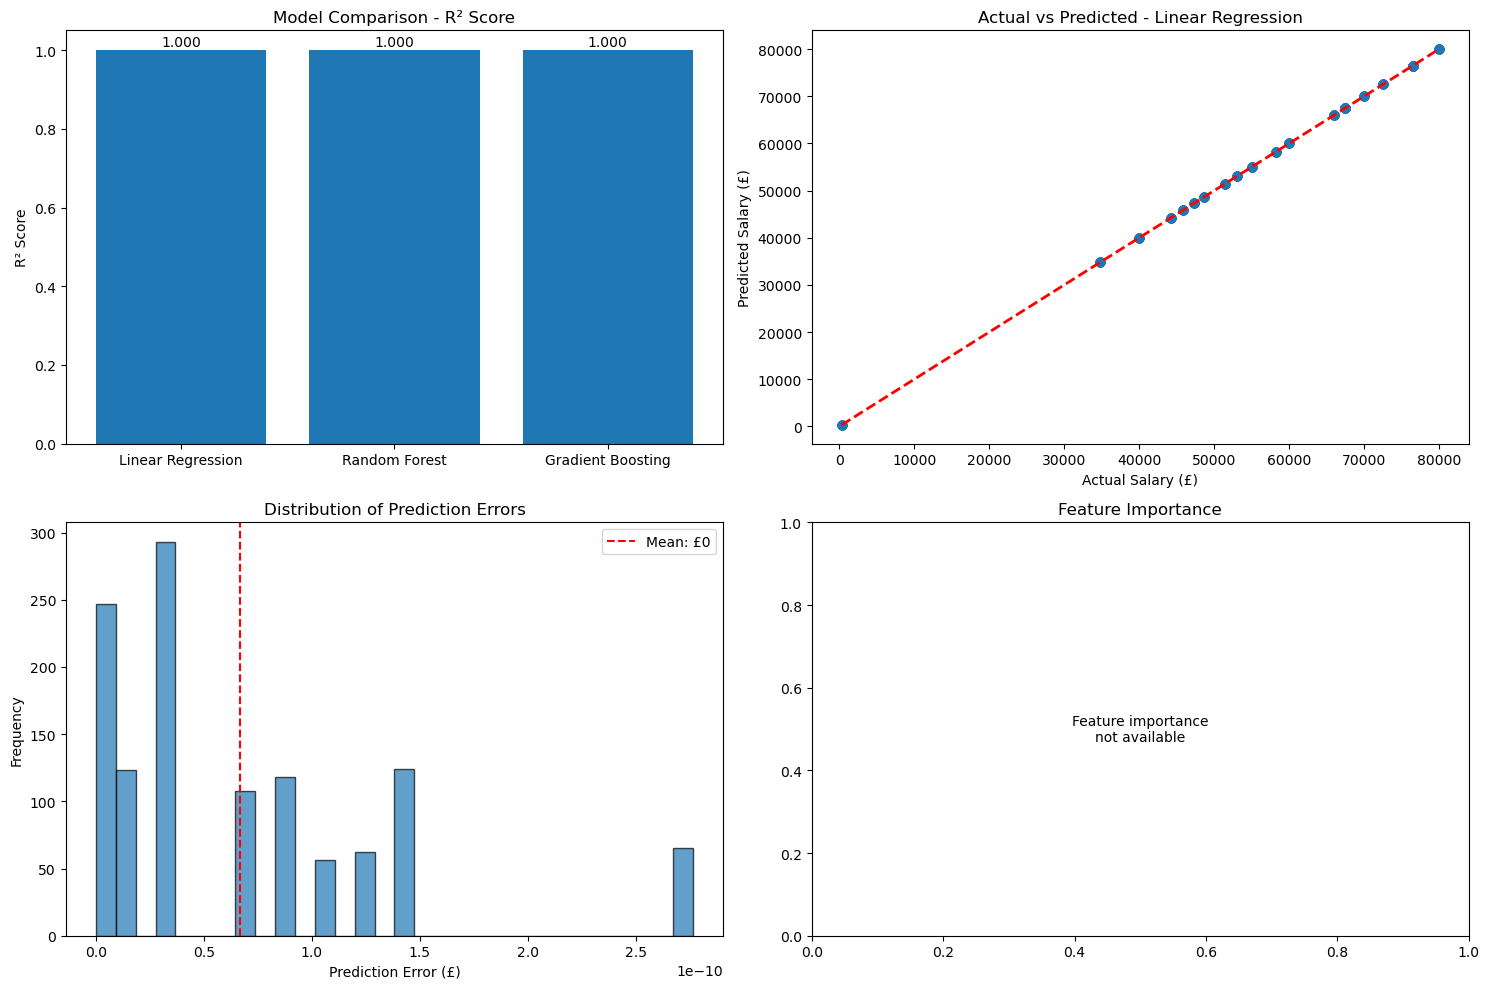


📊 DETAILED PERFORMANCE:
  Average error: £0
  Median error: £0
  90% predictions within: £0
  Average percentage error: 0.0%

💾 Model saved as: best_model_linear_regression.pkl
✅ Training complete! Model ready for predictions.
🎯 Final performance: 100.0% accuracy, ±£0 average error


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("🤖 MACHINE LEARNING MODEL TRAINING")
print("=" * 50)

# Load preprocessed data
X_train_processed = np.load('X_train_processed.npy')
X_test_processed = np.load('X_test_processed.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"Data loaded:")
print(f"  Training: {X_train_processed.shape[0]} samples, {X_train_processed.shape[1]} features")
print(f"  Testing: {X_test_processed.shape[0]} samples")
print(f"  Salary range: £{y_train.min():,.0f} to £{y_train.max():,.0f}")

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models and evaluate performance
results = {}
trained_models = {}

print(f"\nTraining models...")
for name, model in models.items():
    print(f"  Training {name}...")
    
    # Train model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'predictions': y_pred
    }
    trained_models[name] = model

# Compare model performance
results_df = pd.DataFrame(results).T
print(f"\n📊 MODEL PERFORMANCE:")
print(results_df.round(3))

# Select best model
best_model_name = results_df['R²'].idxmax()
best_model = trained_models[best_model_name]
best_r2 = results_df.loc[best_model_name, 'R²']
best_mae = results_df.loc[best_model_name, 'MAE']

print(f"\n🥇 BEST MODEL: {best_model_name}")
print(f"  R² Score: {best_r2:.3f} ({best_r2*100:.1f}% accuracy)")
print(f"  Average Error: £{best_mae:,.0f}")

# Show sample predictions
best_predictions = results[best_model_name]['predictions']
print(f"\n📋 SAMPLE PREDICTIONS:")
print(f"{'Actual':>10} {'Predicted':>10} {'Error':>8}")
print("-" * 30)
for i in range(5):
    actual = y_test[i]
    predicted = best_predictions[i]
    error = abs(actual - predicted)
    print(f"£{actual:>8,.0f} £{predicted:>9,.0f} £{error:>6,.0f}")

# Feature importance (for tree-based models)
if 'Random Forest' in best_model_name or 'Gradient Boosting' in best_model_name:
    try:
        with open('feature_names.txt', 'r') as f:
            feature_names = [line.strip() for line in f.readlines()]
        
        importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n🔝 TOP 10 FEATURE IMPORTANCE:")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
            print(f"  {i:2d}. {row['feature']:<30} {row['importance']:.3f}")
            
    except FileNotFoundError:
        print("\n⚠️  Feature names not found - cannot show importance")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Model comparison
model_names = list(results.keys())
r2_scores = [results[name]['R²'] for name in model_names]
axes[0,0].bar(model_names, r2_scores)
axes[0,0].set_title('Model Comparison - R² Score')
axes[0,0].set_ylabel('R² Score')
for i, v in enumerate(r2_scores):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Actual vs Predicted
axes[0,1].scatter(y_test, best_predictions, alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Salary (£)')
axes[0,1].set_ylabel('Predicted Salary (£)')
axes[0,1].set_title(f'Actual vs Predicted - {best_model_name}')

# Prediction errors
errors = np.abs(y_test - best_predictions)
axes[1,0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1,0].set_xlabel('Prediction Error (£)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Prediction Errors')
axes[1,0].axvline(errors.mean(), color='red', linestyle='--', label=f'Mean: £{errors.mean():,.0f}')
axes[1,0].legend()

# Feature importance plot (if available)
if 'importance_df' in locals():
    top_features = importance_df.head(10)
    axes[1,1].barh(range(len(top_features)), top_features['importance'])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'], fontsize=8)
    axes[1,1].set_xlabel('Importance')
    axes[1,1].set_title('Top 10 Feature Importance')
    axes[1,1].invert_yaxis()
else:
    axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

# Calculate detailed performance metrics
pct_errors = (errors / y_test) * 100
print(f"\n📊 DETAILED PERFORMANCE:")
print(f"  Average error: £{errors.mean():,.0f}")
print(f"  Median error: £{np.median(errors):,.0f}")
print(f"  90% predictions within: £{np.percentile(errors, 90):,.0f}")
print(f"  Average percentage error: {pct_errors.mean():.1f}%")

# Save best model
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"\n💾 Model saved as: {model_filename}")

# Save performance summary
performance_summary = {
    'best_model': best_model_name,
    'r2_score': float(best_r2),
    'mae': float(best_mae),
    'rmse': float(results_df.loc[best_model_name, 'RMSE']),
    'training_samples': len(y_train),
    'test_samples': len(y_test),
    'features_used': X_train_processed.shape[1]
}

import json
with open('model_performance.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

print(f"✅ Training complete! Model ready for predictions.")
print(f"🎯 Final performance: {best_r2*100:.1f}% accuracy, ±£{best_mae:,.0f} average error")

In [ ]:
import dash
from dash import dcc, html, Input, Output, callback
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

# Load your trained model and preprocessor
try:
    # Load the best model (adjust filename if needed)
    model = joblib.load('best_model_linear_regression.pkl')  # or whatever your model file is named
    preprocessor = joblib.load('preprocessor.pkl')
    
    # Load original data for insights
    df = pd.read_csv('dataset_with_features.csv', index_col=0)
    
    print("✅ Model and data loaded successfully!")
    
except FileNotFoundError:
    print("❌ Model files not found. Please train your model first.")
    # Create dummy data for demonstration
    df = pd.DataFrame({
        'location.display_name': ['London', 'Manchester', 'Birmingham'] * 100,
        'company.display_name': ['TechCorp', 'StartupXYZ', 'BigTech'] * 100,
        'avg_salary': np.random.normal(55000, 15000, 300)
    })
    model = None
    preprocessor = None

# Initialize Dash app
app = dash.Dash(__name__)

# Define colors and styling
colors = {
    'background': '#f8f9fa',
    'text': '#2c3e50',
    'primary': '#3498db',
    'success': '#27ae60',
    'warning': '#f39c12',
    'danger': '#e74c3c'
}

# Get unique values for dropdowns
locations = sorted(df['location.display_name'].unique())
companies = sorted(df['company.display_name'].unique())

# App layout
app.layout = html.Div([
    # Header
    html.Div([
        html.H1("💰 JavaScript Developer Salary Predictor", 
                style={'textAlign': 'center', 'color': colors['text'], 'marginBottom': 10}),
        html.P("Predict salaries based on job characteristics using machine learning",
               style={'textAlign': 'center', 'color': colors['text'], 'fontSize': 18})
    ], style={'padding': '20px', 'backgroundColor': colors['background']}),
    
    # Main content
    html.Div([
        # Left panel - Input form
        html.Div([
            html.H3("📝 Job Details", style={'color': colors['text']}),
            
            # Location dropdown
            html.Label("📍 Location:", style={'fontWeight': 'bold', 'marginTop': 10}),
            dcc.Dropdown(
                id='location-dropdown',
                options=[{'label': loc, 'value': loc} for loc in locations],
                value='London',
                style={'marginBottom': 15}
            ),
            
            # Company dropdown
            html.Label("🏢 Company:", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='company-dropdown',
                options=[{'label': comp, 'value': comp} for comp in companies],
                value=companies[0],
                style={'marginBottom': 15}
            ),
            
            # Job category
            html.Label("📂 Job Category:", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='category-dropdown',
                options=[
                    {'label': 'IT Jobs', 'value': 'IT Jobs'},
                    {'label': 'Software Development', 'value': 'Software Development'},
                    {'label': 'Web Development', 'value': 'Web Development'}
                ],
                value='IT Jobs',
                style={'marginBottom': 15}
            ),
            
            # Title length slider
            html.Label("📏 Job Title Length:", style={'fontWeight': 'bold'}),
            dcc.Slider(
                id='title-length-slider',
                min=15, max=70, value=30, step=1,
                marks={i: str(i) for i in range(15, 71, 10)},
                tooltip={"placement": "bottom", "always_visible": True}
            ),
            html.Br(),
            
            # Job characteristics checkboxes
            html.Label("💼 Job Characteristics:", style={'fontWeight': 'bold', 'marginTop': 15}),
            html.Div([
                dcc.Checklist(
                    id='job-characteristics',
                    options=[
                        {'label': ' Senior/Lead Position', 'value': 'is_senior'},
                        {'label': ' Full-Stack Role', 'value': 'is_fullstack'},
                        {'label': ' Frontend Focus', 'value': 'is_frontend'},
                        {'label': ' React Experience', 'value': 'is_react'},
                        {'label': ' Node.js Experience', 'value': 'is_node'},
                    ],
                    value=['is_senior'],
                    style={'marginTop': 10}
                )
            ]),
            
            # Predict button
            html.Br(),
            html.Button('🔮 Predict Salary', id='predict-button', 
                       style={
                           'backgroundColor': colors['primary'],
                           'color': 'white',
                           'padding': '10px 20px',
                           'fontSize': '16px',
                           'border': 'none',
                           'borderRadius': '5px',
                           'cursor': 'pointer',
                           'width': '100%'
                       })
            
        ], style={
            'width': '30%', 
            'display': 'inline-block', 
            'verticalAlign': 'top',
            'padding': '20px',
            'backgroundColor': 'white',
            'margin': '10px',
            'borderRadius': '10px',
            'boxShadow': '0 2px 4px rgba(0,0,0,0.1)'
        }),
        
        # Right panel - Results
        html.Div([
            html.H3("📊 Prediction Results", style={'color': colors['text']}),
            
            # Prediction result
            html.Div(id='prediction-result', style={'marginBottom': 20}),
            
            # Market insights
            html.Div(id='market-insights', style={'marginBottom': 20}),
            
            # Visualization
            dcc.Graph(id='salary-comparison-chart')
            
        ], style={
            'width': '65%', 
            'display': 'inline-block',
            'verticalAlign': 'top',
            'padding': '20px',
            'backgroundColor': 'white',
            'margin': '10px',
            'borderRadius': '10px',
            'boxShadow': '0 2px 4px rgba(0,0,0,0.1)'
        })
        
    ], style={'display': 'flex', 'justifyContent': 'space-around'}),
    
    # Bottom section - Market overview
    html.Div([
        html.H3("📈 Market Overview", style={'color': colors['text'], 'textAlign': 'center'}),
        
        # Summary statistics
        html.Div([
            html.Div([
                html.H4(f"£{df['avg_salary'].mean():,.0f}", style={'color': colors['primary'], 'margin': 0}),
                html.P("Average Salary", style={'margin': 0})
            ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white', 
                     'margin': '10px', 'borderRadius': '10px', 'width': '22%', 'display': 'inline-block'}),
            
            html.Div([
                html.H4(f"£{df['avg_salary'].median():,.0f}", style={'color': colors['success'], 'margin': 0}),
                html.P("Median Salary", style={'margin': 0})
            ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                     'margin': '10px', 'borderRadius': '10px', 'width': '22%', 'display': 'inline-block'}),
            
            html.Div([
                html.H4(f"{len(df):,}", style={'color': colors['warning'], 'margin': 0}),
                html.P("Total Jobs", style={'margin': 0})
            ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                     'margin': '10px', 'borderRadius': '10px', 'width': '22%', 'display': 'inline-block'}),
            
            html.Div([
                html.H4(f"£{df['avg_salary'].std():,.0f}", style={'color': colors['danger'], 'margin': 0}),
                html.P("Salary Range", style={'margin': 0})
            ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': 'white',
                     'margin': '10px', 'borderRadius': '10px', 'width': '22%', 'display': 'inline-block'})
            
        ], style={'textAlign': 'center', 'marginTop': 20})
        
    ], style={'padding': '20px', 'backgroundColor': colors['background']})
    
], style={'fontFamily': 'Arial, sans-serif', 'backgroundColor': colors['background'], 'minHeight': '100vh'})

# Callback for prediction
@app.callback(
    [Output('prediction-result', 'children'),
     Output('market-insights', 'children'),
     Output('salary-comparison-chart', 'figure')],
    [Input('predict-button', 'n_clicks')],
    [Input('location-dropdown', 'value'),
     Input('company-dropdown', 'value'),
     Input('category-dropdown', 'value'),
     Input('title-length-slider', 'value'),
     Input('job-characteristics', 'value')]
)
def update_prediction(n_clicks, location, company, category, title_length, characteristics):
    if n_clicks is None:
        # Default state
        prediction_result = html.Div([
            html.H4("👋 Welcome!", style={'color': colors['text']}),
            html.P("Fill in the job details and click 'Predict Salary' to get started!")
        ])
        
        market_insights = html.Div([
            html.P("💡 Market insights will appear here after prediction")
        ])
        
        # Default chart - salary distribution
        fig = px.histogram(df, x='avg_salary', nbins=30, 
                          title="JavaScript Developer Salary Distribution")
        fig.update_layout(
            xaxis_title="Salary (£)",
            yaxis_title="Number of Jobs",
            plot_bgcolor='white'
        )
        
        return prediction_result, market_insights, fig
    
    # Make prediction
    try:
        # Prepare input data
        input_data = {
            'location.display_name': location,
            'company.display_name': company,
            'category.label': category,
            'title_length': title_length,
            'is_senior': 1 if 'is_senior' in characteristics else 0,
            'is_fullstack': 1 if 'is_fullstack' in characteristics else 0,
            'is_frontend': 1 if 'is_frontend' in characteristics else 0,
            'is_backend': 0,  # Not implemented in this demo
            'is_react': 1 if 'is_react' in characteristics else 0,
            'is_node': 1 if 'is_node' in characteristics else 0,
            'salary_range': 5000,  # Default value
            'is_london': 1 if 'london' in location.lower() else 0,
            'is_remote': 0,  # Not implemented in this demo
            'company_name_length': len(company),
            'days_since_posted': 7,  # Default value
            'salary_category': 'Mid'  # Default value
        }
        
        input_df = pd.DataFrame([input_data])
        
        if model is not None and preprocessor is not None:
            # Transform input data
            input_processed = preprocessor.transform(input_df)
            
            # Make prediction
            predicted_salary = model.predict(input_processed)[0]
        else:
            # Demo prediction (random for demonstration)
            base_salary = 45000
            location_bonus = 15000 if 'london' in location.lower() else 0
            senior_bonus = 12000 if 'is_senior' in characteristics else 0
            fullstack_bonus = 8000 if 'is_fullstack' in characteristics else 0
            predicted_salary = base_salary + location_bonus + senior_bonus + fullstack_bonus
        
        # Prediction result
        prediction_result = html.Div([
            html.H2(f"💰 £{predicted_salary:,.0f}", 
                   style={'color': colors['success'], 'textAlign': 'center', 'margin': 0}),
            html.P("Predicted Annual Salary", 
                   style={'textAlign': 'center', 'fontSize': 18, 'margin': 5}),
            html.Hr(),
            html.P(f"Salary Range: £{predicted_salary*0.9:,.0f} - £{predicted_salary*1.1:,.0f}",
                   style={'textAlign': 'center', 'color': colors['text']})
        ], style={'backgroundColor': '#e8f5e8', 'padding': '20px', 'borderRadius': '10px'})
        
        # Market insights
        market_avg = df['avg_salary'].mean()
        diff_from_market = ((predicted_salary - market_avg) / market_avg) * 100
        
        if abs(diff_from_market) < 5:
            comparison = "close to market average"
            color = colors['primary']
        elif diff_from_market > 0:
            comparison = f"{diff_from_market:.1f}% above market average"
            color = colors['success']
        else:
            comparison = f"{abs(diff_from_market):.1f}% below market average"
            color = colors['warning']
        
        market_insights = html.Div([
            html.P(f"📊 This prediction is {comparison}", 
                   style={'color': color, 'fontWeight': 'bold'}),
            html.P(f"💼 Market average: £{market_avg:,.0f}"),
            html.P(f"📍 Location: {location}"),
            html.P(f"🏢 Company: {company}")
        ])
        
        # Create comparison chart
        comparison_data = {
            'Category': ['Your Prediction', 'Market Average', 'Market Median'],
            'Salary': [predicted_salary, market_avg, df['avg_salary'].median()],
            'Color': [colors['primary'], colors['success'], colors['warning']]
        }
        
        fig = go.Figure(data=[
            go.Bar(x=comparison_data['Category'], 
                   y=comparison_data['Salary'],
                   marker_color=comparison_data['Color'])
        ])
        
        fig.update_layout(
            title="Salary Comparison",
            xaxis_title="Category",
            yaxis_title="Salary (£)",
            plot_bgcolor='white',
            showlegend=False
        )
        
        return prediction_result, market_insights, fig
        
    except Exception as e:
        error_result = html.Div([
            html.H4("❌ Prediction Error", style={'color': colors['danger']}),
            html.P(f"Error: {str(e)}")
        ])
        return error_result, "", {}

# Run the app
if __name__ == '__main__':
    print("🚀 Starting Dash app...")
    print("📱 Open your browser and go to: http://127.0.0.1:8050")
    app.run(debug=True)

✅ Model and data loaded successfully!
🚀 Starting Dash app...
📱 Open your browser and go to: http://127.0.0.1:8050


ObsoleteAttributeException: app.run_server has been replaced by app.run